<a href="https://colab.research.google.com/github/KauaHenSilva/python_identifies_human/blob/main/fisherfaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação

In [129]:
from google.colab.drive import mount
from google.colab.patches import cv2_imshow
from PIL import Image
import cv2
import zipfile
import os
import numpy as np

In [130]:
# drive: https://drive.google.com/drive/folders/1OXTbhGlG6Y-x6hMY_5Y8Ed3mPB9lP5LF?usp=sharing
mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reconhecimento de faces com Fisherfaces

## Carregando base de dados

In [131]:
path = "/content/drive/MyDrive/Face Detection and Recognition/datasets/yalefaces.zip"
zip_obj = zipfile.ZipFile(path, 'r')
zip_obj.extractall('./')
zip_obj.close()

## Deteção e recorte da face (SSD)

In [132]:
prototxt = "/content/drive/MyDrive/Face Detection and Recognition/weights/deploy.prototxt.txt"
model = "/content/drive/MyDrive/Face Detection and Recognition/weights/res10_300x300_ssd_iter_140000.caffemodel"
network = cv2.dnn.readNetFromCaffe(prototxt, model)

In [133]:
def run_ssd_recort(net, img_path, conf_min = 0.8, tamanho = 100):
    imagem = Image.open(img_path).convert("L")
    imagem = np.array(imagem, 'uint8')
    imagem = cv2.cvtColor(imagem, cv2.COLOR_GRAY2BGR)
    (h, w) = imagem.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(imagem, (tamanho, tamanho)), 1.0, (tamanho, tamanho), (104, 117, 123))
    net.setInput(blob)
    deteccoes = net.forward()


    for i in range(0, deteccoes.shape[2]):
      confianca_atual = deteccoes[0, 0, i, 2]
      if confianca_atual >= conf_min:
        confianca_da_face = confianca_atual
        text_conf = f"{(confianca_atual * 100):.2f}%"
        box = deteccoes[0, 0, i, 3:7] * np.array([w, h, w, h])
        (start_x, start_y, end_x, end_y) = box.astype(int)

        cv2.putText(imagem, f"{text_conf}", (start_x, start_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 0, lineType=cv2.LINE_AA)
        cv2.rectangle(imagem, (start_x - 1, start_y - 1), (end_x + 1, end_y + 1), (0,255,0), 1)
        face = imagem[start_y:end_y, start_x:end_x]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

    return imagem, cv2.resize(face, (60, 80)), confianca_da_face

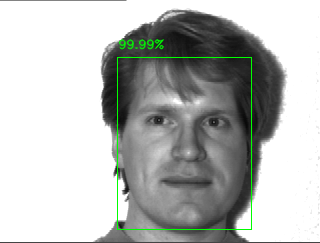

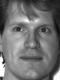

(0.9999467, (80, 60))

In [134]:
imagem_test = "/content/yalefaces/test/subject01.gif"
(img, face, confianca) = run_ssd_recort(network, imagem_test, 0.8)
cv2_imshow(img)
cv2_imshow(face)
confianca, face.shape

## Construção da base de dados

In [135]:
def get_imagens_data():
  path_past_train = "/content/yalefaces/train"
  paths = [os.path.join(path_past_train, f) for f in os.listdir(path_past_train)]

  imgs = []
  faces = []
  ids = []

  for path in paths:
    id = int(path.split('.')[0].split('subject')[-1])
    img, face, confianca =  run_ssd_recort(network, path, 0.7)
    cv2.putText(img, f"{id}", (20, img.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 0, lineType=cv2.LINE_AA)

    imgs.append(img)
    faces.append(face)
    ids.append(id)

  return imgs, faces, np.array(ids)

## Fisherfaces

In [143]:
imgs, faces, ids = get_imagens_data()
fisher_classifier = cv2.face.FisherFaceRecognizer_create()
fisher_classifier.train(faces, ids)
fisher_classifier.write('fisher_classifier.yml')

In [144]:
fisher_classifier = cv2.face.FisherFaceRecognizer_create()
fisher_classifier.read('/content/fisher_classifier.yml')

In [147]:
def teste_reconhecimento(path_imagem_teste, classificador):
  img_test, face, conf = run_ssd_recort(network, path_imagem_teste)
  previsao, conf = classificador.predict(face)
  saida_esperada = int(os.path.split(path_imagem_teste)[1].split('.')[0].replace('subject', ''))
  cv2.putText(img_test, 'Pred: ' + str(previsao), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (0,255,0))
  cv2.putText(img_test, 'Exp: ' + str(saida_esperada), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (0,255,0))
  return img_test, previsao, conf

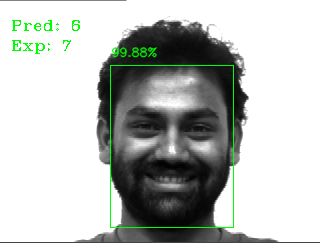

(6, 955.0323305053125)

In [148]:
img, prev, conf = teste_reconhecimento("/content/yalefaces/test/subject07.happy.gif", ficher_classifier)
cv2_imshow(img)
prev, conf

## Avaliação

In [149]:
import seaborn
from sklearn.metrics import confusion_matrix, accuracy_score

In [150]:
def avalia_algoritmo(paths, classificador):
  previsoes = []
  saidas_esperadas = []
  qtd_face_nao_reconhecida = 0

  for path in paths:
    img, face, conf = run_ssd_recort(network, path)
    previsao, conf = classificador.predict(face)
    saida_esperada = int(path.split('.')[0].split('subject')[-1])

    previsoes.append(previsao)
    saidas_esperadas.append(saida_esperada)

    if previsao == -1:
       qtd_face_nao_reconhecida += 1

  return np.array(previsoes), np.array(saidas_esperadas), qtd_face_nao_reconhecida

def test_avaliacao_grafico(paths, classificador):
    previsoes, saidas, qtd_nao_reconhecida = avalia_algoritmo(paths, classificador)
    print(f"acuracia: {accuracy_score(saidas, previsoes)}", f"qtd não reconhecida: {qtd_nao_reconhecida}")
    seaborn.heatmap(confusion_matrix(saidas, previsoes), annot=True);

## ALERTA: APÓS ATUALIZAÇÕES ESSE CLASSIFICADOR TEVE UMA QUEDA BRUTA DE DESEMPENHO

In [155]:
cv2.version.opencv_version

'4.10.0.84'

acuracia: 0.5666666666666667 qtd não reconhecida: 0


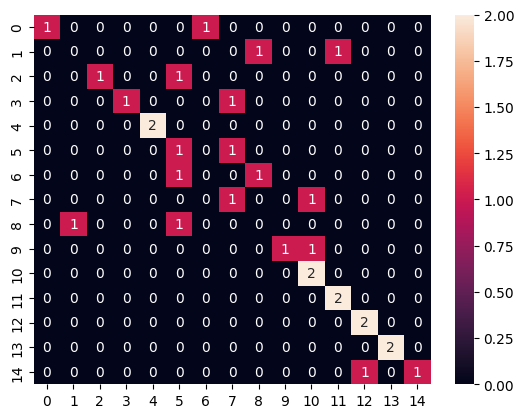

In [152]:
path_past_test = "/content/yalefaces/test"
paths = [os.path.join(path_past_test, f) for f in os.listdir(path_past_test)]
test_avaliacao_grafico(paths, fisher_classifier)